<a href="https://colab.research.google.com/github/ipeirotis/sql_autograding/blob/main/3_5_turbo_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install -U openai
!pip install -q google-cloud-secret-manager
!pip install -U PyMySQL sqlalchemy

In [24]:
import gcsfs
import pandas as pd
import io
import openai
import os
import numpy as np

from google.cloud import secretmanager

from google.colab import auth

import requests

from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split

from sqlalchemy import text

In [25]:
# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [26]:
def access_secret_version(project_id, secret_id, version_id):
    """
    Access the payload of the given secret version and return it.

    Args:
        project_id (str): Google Cloud project ID.
        secret_id (str): ID of the secret to access.
        version_id (str): ID of the version to access.
    Returns:
        str: The secret version's payload, or None if
        the version does not exist.
    """
    try:
        client = secretmanager.SecretManagerServiceClient()
        name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
        response = client.access_secret_version(request={"name": name})
        return response.payload.data.decode("UTF-8")
    except Exception as e:
        print(f"Failed to access the secret version: {e}")
        return None


openai_key = access_secret_version("sql-autograding", "openai-gpt4-32k", "latest")
openai.api_key = openai_key

In [27]:
URL = "https://api.openai.com/v1/chat/completions"

from openai import OpenAI

client = OpenAI(
  api_key=openai_key,  # this is also the default, it can be omitted
)

In [28]:
# read the dataset
fs = gcsfs.GCSFileSystem(project="sql_autograding")
with fs.open("gs://sql_autograding/clean_submissions_final.csv") as f:
    data = pd.read_csv(f)

data = data.drop(columns="Unnamed: 0")
data.head()

,QuestionID,SubmittedAnswer,StudentID,Score
0,50,"SELECT A.CustomerID, A.CompanyName,...",ab3864,10.0
1,54,"SELECT O.CustomerID, SUM(D.Quantity * D....",ab3864,6.5
2,55,"Select O.OrderID, O.CustomerID, Count(D.Produ...",ab3864,5.5
3,61,"use northwind; SELECT ShipCountry, AVG(...",ab3864,7.0
4,56,"Select C.CompanyName, C.CustomerID, sum(case w...",ab3864,10.0


In [29]:
# if imported cleaned_submissions_final.csv, comment below
with fs.open("gs://sql_autograding/Database Homeworks.csv") as f:
    hw = pd.read_csv(f)

data = pd.merge(data, hw, how='left', on='QuestionID')
data['full_score'] = data.groupby('QuestionID')['Score'].transform('max')
data.head()

,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score
0,50,"SELECT A.CustomerID, A.CompanyName,...",ab3864,10.0,Final Exam,Hard question. Requires use of subqueries and ...,northwind,"WITH total_spent AS ( SELECT C.CustomerID, C.C...",10.0
1,54,"SELECT O.CustomerID, SUM(D.Quantity * D....",ab3864,6.5,Final Exam,"For each customer, we want to calculate how mu...",northwind,"SELECT C.CustomerID, C.CompanyName , COALESCE(...",10.0
2,55,"Select O.OrderID, O.CustomerID, Count(D.Produ...",ab3864,5.5,Final Exam,"For each order, show the customerID who placed...",northwind,"SELECT O.OrderID, O.CustomerID , SUM(D.Quantit...",10.0
3,61,"use northwind; SELECT ShipCountry, AVG(...",ab3864,7.0,Final Exam,We want to identify the ship countries with th...,northwind,"SELECT ShipCountry, ROUND(AVG(Freight),2) AS A...",7.5
4,56,"Select C.CompanyName, C.CustomerID, sum(case w...",ab3864,10.0,Final Exam,For every customer in the database list the nu...,northwind,"SELECT C.CustomerID, COUNT(O.OrderID) AS order...",10.0


In [30]:
# open a file with GPT 4 grade & feedback
with fs.open("gs://sql_autograding/few_shots_cleaned_final.csv") as f:
    data1 = pd.read_csv(f)

data1 = data1.drop(columns=['Unnamed: 0', '3_few_mp', '3_answer', '3_grade', '3_feedback', 'num', '4_grade', '3_grade_scaled', '4_error', '3_error'])
data1.head()

,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,schema,full_score,4_few_mp,4_answer,4_feedback,4_grade_scaled
0,63,"SELECT FirstName, LastName, HireDate FROM Emp...",amc10323,5.0,Final Exam,"We would like to see just the FirstName, LastN...",northwind,"SELECT FirstName, LastName, HireDate FROM Empl...","[{'Categories': ['CategoryID', 'CategoryName',...",5.0,\n a. We are working with the northwind d...,Grade: 10/10\n\nFeedback: Excellent job! Your ...,Excellent job! Your SQL query is correct and i...,5.0
1,16,"select T.track_name, A.artist_name, AL.album_n...",jd2855,0.0,Assignment 3: Joins,"List all the track names, the corresponding al...",music,"SELECT track_name, artist_name, album_name FRO...","[{'album': ['artist_id', 'album_id', 'album_na...",1.0,\n a. We are working with the music datab...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,Great job! Your SQL query correctly joins the ...,1.0
2,3,SELECT * FROM album;,mc10018,0.0,Assignment 2B: Selection Queries,Show all the albums.,music,SELECT * FROM album,"[{'album': ['artist_id', 'album_id', 'album_na...",1.0,\n a. We are working with the music datab...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,Great job! Your SQL query is correct and it wi...,1.0
3,0,Select artist_name from artist order by arti...,lka2053,0.0,Assignment 2B: Selection Queries,"List all the names of the artists, without the...",music,SELECT artist_name FROM artist ORDER BY artist...,"[{'album': ['artist_id', 'album_id', 'album_na...",1.0,\n a. We are working with the music datab...,Grade: 10/10\n\nFeedback: Your answer is corre...,Your answer is correct. You have successfully ...,1.0
4,24,"use music; SELECT A.artist_id, COUNT(B.album_...",sf4210,0.0,Assignment 4: Aggregations,"For each artist, count the number of albums in...",music,"SELECT artist_id, COUNT(album_id) AS cnt_album...","[{'album': ['artist_id', 'album_id', 'album_na...",11.0,\n a. We are working with the music datab...,Grade: 10/10\n\nFeedback: Great job! Your SQL ...,Great job! Your SQL query correctly counts the...,11.0


### Fine-tuned turbo model: generate few-shot feedback for 300 samples other than training set with the same index with data

In [31]:
# filter all rows that cannot be used
indices_to_use = [i for i in data.index if i not in (data1.index.values)]
data = data.loc[indices_to_use]
data = data[data['full_score']>0]

In [32]:
db_list = [
    "flights",
    "imdb",
    "music",
    "restaurants",
    "facebook",
    "northwind",
    "collisions",
]


def db_schema(db_name):
    """
    Connects to a database and returns the schema of each table in the database.

    The function connects to a specific database using SQLAlchemy. It then retrieves the list of tables in
    the database and for each table, it queries the schema (i.e., the list of fields/columns) and stores it
    in a dictionary. The function returns a list of such dictionaries, with each dictionary representing a table
    and its corresponding schema.

    Args:
        db_name (str): The name of the database to connect to and retrieve schemas from.

    Returns:
        list: A list of dictionaries, with each dictionary containing the name of a table as the key and a
              list of its fields as the value.

    Example:
        >>> db_schema('flights')
        {'m_airports': ['airport', 'state', 'state_name']},
        {'m_ticket_prices': ['origin', 'dest', 'carrier', 'fare', 'fare_per_mile','passengers', 'distance']
        ...
        },
    """

    student_password = access_secret_version(
        "sql-autograding", "db_student_password", "1"
    )

    conn_string = (
        "mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4".format(
            host="db.ipeirotis.org",
            user="student",
            password=student_password,
            db=db_name,
            encoding="utf8mb4",
        )
    )
    engine = create_engine(conn_string)

    with engine.begin() as conn:
        tables = pd.read_sql_query(sql=text("show tables"), con=conn)
        tables = tables.iloc[:, -1].tolist()

        schema_list = []
        for t in tables:
            d = pd.read_sql_query(sql=text(f"describe {t}"), con=conn)
            table_schema = {t: d.loc[:, "Field"].tolist()}
            schema_list.append(table_schema)
    return schema_list

flights_schema = db_schema("flights")
imdb_schema = db_schema("imdb")
music_schema = db_schema("music")
restaurants_schema = db_schema("restaurants")
facebook_schema = db_schema("facebook")
northwind_schema = db_schema("northwind")
collisions_schema = db_schema("collisions")

schema_mapping = {
    "flights": flights_schema,
    "imdb": imdb_schema,
    "music": music_schema,
    "restaurants": restaurants_schema,
    "facebook": facebook_schema,
    "northwind": northwind_schema,
    "collisions": collisions_schema,
    "['northwind', 'flights']": (northwind_schema, flights_schema),
}

data["schema"] = data["Database"].map(schema_mapping)

from bs4 import BeautifulSoup

# Create a function to clean up a single text string
def clean_html_content(text):
    if pd.isna(text):
        return text
    if not isinstance(text, str):
        text = str(text)
    try:
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    except:
        return text


# Apply the function to every text column in your DataFrame
for col in data.columns:
    if col in ("Database", "schema"):
        continue
    if data[col].dtype == object:  # if the column is a text column
        data[col] = data[col].apply(clean_html_content)

<ipython-input-32-eb701357c272>:92: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [33]:
# from typing import List


# def generate_submissions_string(
#     train_df: pd.DataFrame, submission_size: int = None
# ) -> str:
#     """
#     Generate a string that concatenates student submissions up to the given size.

#     Args:
#         train_df (pd.DataFrame): The DataFrame containing the training data.
#         submission_size (int, optional): The number of submissions to include in the string. If None, include all submissions.

#     Returns:
#         str: A string containing the concatenated submissions.
#     """
#     submissions = ""
#     for i, row in train_df.iterrows():
#         if submission_size is not None and i >= submission_size:
#             break
#         submission = row["InputUserAnswer"]
#         grade = row["Score"]
#         full_grade = row["full_score"]
#         feedback = row["feedback"]
#         submissions += f"e{i}. submission: {submission}, grade: {grade}/{full_grade}, feedback: {feedback} \\n\\n"
#     return submissions


# def generate_mega_prompt_for_id(
#     df: pd.DataFrame, id: str, submission_size: int = None
# ) -> str:
#     """
#     Generate a mega prompt for a specific QuestionId.

#     Args:
#         df (pd.DataFrame): The DataFrame containing the data.
#         id (str): The QuestionId to generate the mega prompt for.
#         submission_size (int, optional): The number of submissions to include in the mega prompt. If None, include all submissions.

#     Returns:
#         str: The mega prompt.
#     """
#     temp = df[df["QuestionId"] == id]

#     # If there's only one row or less, return None or handle it in a special way
#     if len(temp) == 0:
#       return None
#     if len(temp) == 1:
#       # return the only row as test answer
#       temp = temp.reset_index()
#       submissions = ''
#       db = temp.loc[0, "Database"]
#       tables = temp.loc[0, "schema"]
#       question = temp.loc[0, "Question"]
#       key = temp.loc[0, "AnswerKey"]

#       test = temp.loc[0, "InputUserAnswer"]

#       mega_p = f"""
#         a. We are working with the {db} database, which has the following tables: {tables}

#         b. The request to the student is "{question}"

#         c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

#         d. The student answer was {test}

#         e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

#         Please provide a grade (out of 10 points) and feedback for the student
#         """
#       return mega_p

#     # making test size 1
#     train_df, test_df = train_test_split(temp, test_size=1, random_state=1234)
#     train_df = train_df.reset_index()
#     test_df = test_df.reset_index()

#     submissions = generate_submissions_string(train_df, submission_size)

#     db = train_df.loc[0, "Database"]
#     tables = train_df.loc[0, "schema"]
#     question = train_df.loc[0, "Question"]
#     key = train_df.loc[0, "AnswerKey"]

#     test = test_df.loc[0, "InputUserAnswer"]

#     mega_p = f"""
#       a. We are working with the {db} database, which has the following tables: {tables}

#       b. The request to the student is "{question}"

#       c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

#       d. The student answer was {test}

#       e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

#       Please provide a grade and feedback for the student
#       """
#     return mega_p


# def generate_mega_prompts(
#     df: pd.DataFrame, submission_size: int = None
# ) -> pd.DataFrame:
#     """
#     Generate a DataFrame of mega prompts for each unique QuestionId in the given DataFrame.

#     Args:
#         df (pd.DataFrame): The DataFrame containing the data.
#         submission_size (int, optional): The number of submissions to include in each mega prompt. If None, include all submissions.

#     Returns:
#         pd.DataFrame: A DataFrame containing the mega prompts.
#     """
#     result = []
#     qids = df["QuestionId"].unique()

#     for id in qids:
#         mega_p = generate_mega_prompt_for_id(df, id, submission_size)
#         new_row = {"QuestionId": id, "MegaPrompt": mega_p}
#         result.append(new_row)

#     mega_df = pd.DataFrame(result)

#     return mega_df

In [34]:
# # A function that generates few-shot mega-prompts for a row given the expected number of submissions
# from numpy import row_stack
# def generate_fewshot_prompt_for_row(
#     test, submission_size: int = None
# ) -> str:
#     """
#     Generate a mega prompt for a specific QuestionId.

#     Args:
#         test (pd.DataFrame): The DataFrame - this row.
#         submission_size (int, optional): The number of submissions to include in the mega prompt. If None, include all submissions.

#     Returns:
#         str: The mega prompt.
#     """
#     temp = data[data["QuestionId"] == test['QuestionId']]

#     # If there's only one row or less, return None or handle it in a special way
#     if len(temp) == 0:
#       return None
#     if len(temp) == 1:
#       # return the only row as test answer
#       temp = temp.reset_index()
#       submissions = ''
#       db = temp.loc[0, "Database"]
#       tables = temp.loc[0, "schema"]
#       question = temp.loc[0, "Question"]
#       key = temp.loc[0, "AnswerKey"]

#       test = temp.loc[0, "InputUserAnswer"]

#       mega_p = f"""
#         a. We are working with the {db} database, which has the following tables: {tables}

#         b. The request to the student is "{question}"

#         c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

#         d. The student answer was {test}

#         e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

#         Please provide a grade (out of 10 points) and feedback for the student
#         """
#       return mega_p

#     # skip the current row
#     temp = temp[temp['NetId']!=test['NetId']]
#     if submission_size==None:
#       train_df = temp.copy().reset_index()
#     else:
#       # randomly sampling certain size of training rows for the same QuestionId
#       train_df = temp.sample(n=submission_size).reset_index()

#     submissions = generate_submissions_string(train_df)

#     db = train_df.loc[0, "Database"]
#     tables = train_df.loc[0, "schema"]
#     question = train_df.loc[0, "Question"]
#     key = train_df.loc[0, "AnswerKey"]
#     test = test['InputUserAnswer']

#     mega_p = f"""
#       a. We are working with the {db} database, which has the following tables: {tables}

#       b. The request to the student is "{question}"

#       c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

#       d. The student answer was {test}

#       e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

#       Please provide a grade and feedback for the student.

#       """ + """Only provide a RFC8259 compliant JSON response following this format without deviation. {"grade": "the grade out of 10 you give", "feedback": "the feedback you give"}"""
#     return mega_p


In [35]:
from typing import List

def generate_submissions_string(
    train_df: pd.DataFrame, submission_size: int = None
) -> str:
    """
    Generate a string that concatenates student submissions up to the given size.

    Args:
        train_df (pd.DataFrame): The DataFrame containing the training data.
        submission_size (int, optional): The number of submissions to include in the string. If None, include all submissions.

    Returns:
        str: A string containing the concatenated submissions.
    """
    submissions = ""
    for i, row in train_df.iterrows():
        if submission_size is not None and i >= submission_size:
            break
        submission = row["SubmittedAnswer"]
        grade = row["Score"]
        full_grade = row["full_score"]
        submissions += f"e{i}. submission: {submission}, grade: {grade}/{full_grade}\\n\\n"
    return submissions


def generate_mega_prompt_for_id(
    df: pd.DataFrame, id: str, submission_size: int = None
) -> str:
    """
    Generate a mega prompt for a specific QuestionId.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        id (str): The QuestionId to generate the mega prompt for.
        submission_size (int, optional): The number of submissions to include in the mega prompt. If None, include all submissions.

    Returns:
        str: The mega prompt.
    """
    temp = df[df["QuestionID"] == id]

    # If there's only one row or less, return None or handle it in a special way
    if len(temp) == 0:
      return None
    if len(temp) == 1:
      # return the only row as test answer
      temp = temp.reset_index()
      submissions = ''
      db = temp.loc[0, "Database"]
      tables = temp.loc[0, "schema"]
      question = temp.loc[0, "Question"]
      key = temp.loc[0, "AnswerKey"]
      full_score = temp.loc[0, "full_score"]
      test = temp.loc[0, "SubmittedAnswer"]

      mega_p = f"""
        a. We are working with the {db} database, which has the following tables: {tables}

        b. The request to the student is "{question}"

        c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

        d. The student answer was {test}

        e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

       Please provide a grade and feedback for the student.

      """ + """Only provide a RFC8259 compliant JSON response following this format without deviation. {"grade": "the grade out of 10 you give", "feedback": "the feedback you give"}"""
      return mega_p

    # making test size 1
    train_df, test_df = train_test_split(temp, test_size=1, random_state=1234)
    train_df = train_df.reset_index()
    test_df = test_df.reset_index()

    submissions = generate_submissions_string(train_df, submission_size)

    db = train_df.loc[0, "Database"]
    tables = train_df.loc[0, "schema"]
    question = train_df.loc[0, "Question"]
    key = train_df.loc[0, "AnswerKey"]
    full_score = temp.loc[0, "full_score"]
    test = test_df.loc[0, "SubmittedAnswer"]

    mega_p = f"""
      a. We are working with the {db} database, which has the following tables: {tables}

      b. The request to the student is "{question}"

      c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

      d. The student answer was {test}

      e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

      Please provide a grade and feedback for the student.

      """ + """Only provide a RFC8259 compliant JSON response following this format without deviation. {"grade": "the grade out of 10 you give", "feedback": "the feedback you give"}"""
    return mega_p


def generate_mega_prompts(
    df: pd.DataFrame, submission_size: int = None
) -> pd.DataFrame:
    """
    Generate a DataFrame of mega prompts for each unique QuestionId in the given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        submission_size (int, optional): The number of submissions to include in each mega prompt. If None, include all submissions.

    Returns:
        pd.DataFrame: A DataFrame containing the mega prompts.
    """
    result = []
    qids = df["QuestionID"].unique()

    for id in qids:
        mega_p = generate_mega_prompt_for_id(df, id, submission_size)
        new_row = {"QuestionID": id, "MegaPrompt": mega_p}
        result.append(new_row)

    mega_df = pd.DataFrame(result)

    return mega_df

In [36]:
# A function that generates few-shot mega-prompts for a row given the expected number of submissions
from numpy import row_stack
def generate_fewshot_prompt_for_row(
    test, submission_size: int = None
) -> str:
    """
    Generate a mega prompt for a specific QuestionId.

    Args:
        test (pd.DataFrame): The DataFrame - this row.
        submission_size (int, optional): The number of submissions to include in the mega prompt. If None, include all submissions.

    Returns:
        str: The mega prompt.
    """
    temp = data[data["QuestionID"] == test['QuestionID']]

    # If there's only one row or less, return None or handle it in a special way
    if len(temp) == 0:
      return None
    if len(temp) == 1:
      # return the only row as test answer
      temp = temp.reset_index()
      submissions = ''
      db = temp.loc[0, "Database"]
      tables = temp.loc[0, "schema"]
      question = temp.loc[0, "Question"]
      key = temp.loc[0, "AnswerKey"]

      test = temp.loc[0, "SubmittedAnswer"]

      mega_p = f"""
        a. We are working with the {db} database, which has the following tables: {tables}

        b. The request to the student is "{question}"

        c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

        d. The student answer was {test}

        e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

        Please provide a grade and feedback for the student.

      """ + """Only provide a RFC8259 compliant JSON response following this format without deviation. {"grade": "the grade out of 10 you give", "feedback": "the feedback you give"}"""
      return mega_p

    # skip the current row
    temp = temp[temp['StudentID']!=test['StudentID']]
    if submission_size==None or submission_size >= temp.shape[0]:
      train_df = temp.copy().reset_index()
    else:
      # randomly sampling certain size of training rows for the same QuestionId
        train_df = temp.sample(n=submission_size).reset_index()

    submissions = generate_submissions_string(train_df)

    db = train_df.loc[0, "Database"]
    tables = train_df.loc[0, "schema"]
    question = train_df.loc[0, "Question"]
    key = train_df.loc[0, "AnswerKey"]
    test = test['SubmittedAnswer']

    mega_p = f"""
      a. We are working with the {db} database, which has the following tables: {tables}

      b. The request to the student is "{question}"

      c. The model answer is {key} (note that we may have multiple correct answers, the model answer is just an example)

      d. The student answer was {test}

      e. Previously, students have submitted these answers and got back these responses and grades: \\n{submissions}

      Please provide a grade and feedback for the student.

      """ + """Only provide a RFC8259 compliant JSON response following this format without deviation. {"grade": "the grade out of 10 you give", "feedback": "the feedback you give"}"""
    return mega_p


In [37]:
pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.


In [38]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name="cl100k_base") -> int:
  encoding = tiktoken.get_encoding(encoding_name)
  num_tokens = len(encoding.encode(string))
  return num_tokens

In [39]:
def max_submission_size(t, max_size):
  idf = data[data["QuestionID"] == t['QuestionID']]
  for i in range(1,len(idf)-1):
    mp = generate_fewshot_prompt_for_row(t,i)
    if num_tokens_from_string(mp, "cl100k_base") >= max_size:
      return i-1
  return None

In [40]:
# resample 400 rows from preprocessed dataset, generate few-shot prompts
data2, _ = train_test_split(data, train_size=400, stratify=data['QuestionID'], random_state=1234)
data2 = data2.reset_index()
data2.head()

,index,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score,schema
0,2268,6,use music; select * from track;,js11592,1.0,Assignment 2B: Selection Queries,Show all the tracks.,music,SELECT * FROM track,1.0,"[{'album': ['artist_id', 'album_id', 'album_na..."
1,4104,52,"select carrier, count(dest), count(origin), av...",lka2053,10.0,Final Exam,Flights: Using the table flights.m_ticket_pric...,flights,"SELECT carrier, COUNT(*) AS routes, COUNT(DIST...",10.0,"[{'airports': ['airport', 'state', 'state_name..."
2,4452,25,"SELECT DATE(P.played_on) as date_played, A.art...",rm6409,1.0,Assignment 4: Aggregations,For every date listed in the tracked_played ta...,music,"SELECT DATE(played_on) AS date_played, A.artis...",1.0,"[{'album': ['artist_id', 'album_id', 'album_na..."
3,10420,38,CREATE TEMPORARY TABLE female_only AS SELECT ...,amc10323,0.5,Assignment 5: Subqueries,Find the eligible names (see definition of eli...,imdb,CREATE TEMPORARY TABLE female_names AS SELECT ...,1.0,"[{'actors': ['id', 'first_name', 'last_name', ..."
4,10199,13,select artist_name from artist where artist_...,li2116,1.0,Assignment 2C: Filtering Queries,Show the entry for the artist with id equal to 5.,music,SELECT * FROM artist WHERE artist_id = 5,1.0,"[{'album': ['artist_id', 'album_id', 'album_na..."


In [41]:
from tqdm import tqdm
import json

lst = []
for i, r in tqdm(data2.iterrows(), total=len(data2)):
  s_size = max_submission_size(r, 2500) # max # of tokens = 4096
  lst.append(generate_fewshot_prompt_for_row(r,s_size))

data2['3_few_mp'] = lst

data2['num'] = data2['3_few_mp'].apply(num_tokens_from_string)
print(data2['num'].max())
data2.head()

100%|██████████| 400/400 [01:58<00:00,  3.36it/s]


3308


,index,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score,schema,3_few_mp,num
0,2268,6,use music; select * from track;,js11592,1.0,Assignment 2B: Selection Queries,Show all the tracks.,music,SELECT * FROM track,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,1637
1,4104,52,"select carrier, count(dest), count(origin), av...",lka2053,10.0,Final Exam,Flights: Using the table flights.m_ticket_pric...,flights,"SELECT carrier, COUNT(*) AS routes, COUNT(DIST...",10.0,"[{'airports': ['airport', 'state', 'state_name...",\n a. We are working with the flights dat...,1936
2,4452,25,"SELECT DATE(P.played_on) as date_played, A.art...",rm6409,1.0,Assignment 4: Aggregations,For every date listed in the tracked_played ta...,music,"SELECT DATE(played_on) AS date_played, A.artis...",1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2487
3,10420,38,CREATE TEMPORARY TABLE female_only AS SELECT ...,amc10323,0.5,Assignment 5: Subqueries,Find the eligible names (see definition of eli...,imdb,CREATE TEMPORARY TABLE female_names AS SELECT ...,1.0,"[{'actors': ['id', 'first_name', 'last_name', ...",\n a. We are working with the imdb databa...,2540
4,10199,13,select artist_name from artist where artist_...,li2116,1.0,Assignment 2C: Filtering Queries,Show the entry for the artist with id equal to 5.,music,SELECT * FROM artist WHERE artist_id = 5,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2206


In [42]:
# new GPT3_backoff method with turbo model, generating responses for each row, save to a new dataset
import time
# further control rate limit for GPT-4
rate_limit_per_minute = 40000
delay = 60.0 / rate_limit_per_minute

from tenacity import(retry, stop_after_attempt, wait_random_exponential)
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def GPT3_generation_with_backoff(prompt):
    response = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-0613:nyu::8P5asqAB",
        messages=[{"role": "user", "content": prompt}],
        n=1,
        stream=False,
        temperature=0.0,
        max_tokens=600,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )
    return response.choices[0].message.content

def delayed_completion(p):
  time.sleep(delay)
  return GPT3_generation_with_backoff(p)

In [43]:
tqdm.pandas()
data2['3_answer'] = data2['3_few_mp'].progress_apply(GPT3_generation_with_backoff)

100%|██████████| 400/400 [07:35<00:00,  1.14s/it]


In [49]:
data2.head()

,index,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score,schema,3_few_mp,num,3_answer,3_grade,3_feedback
0,2268,6,use music; select * from track;,js11592,1.0,Assignment 2B: Selection Queries,Show all the tracks.,music,SELECT * FROM track,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,1637,"{""grade"": ""0.0"", ""feedback"": ""The SQL query yo...",0.0,The SQL query you provided is incorrect. The c...
1,4104,52,"select carrier, count(dest), count(origin), av...",lka2053,10.0,Final Exam,Flights: Using the table flights.m_ticket_pric...,flights,"SELECT carrier, COUNT(*) AS routes, COUNT(DIST...",10.0,"[{'airports': ['airport', 'state', 'state_name...",\n a. We are working with the flights dat...,1936,"{""grade"": ""7.5"", ""feedback"": ""Your SQL query i...",7.5,Your SQL query is mostly correct and you have ...
2,4452,25,"SELECT DATE(P.played_on) as date_played, A.art...",rm6409,1.0,Assignment 4: Aggregations,For every date listed in the tracked_played ta...,music,"SELECT DATE(played_on) AS date_played, A.artis...",1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2487,"{""grade"": ""9.0"", ""feedback"": ""Great job! Your ...",9.0,Great job! Your SQL query is correct and it me...
3,10420,38,CREATE TEMPORARY TABLE female_only AS SELECT ...,amc10323,0.5,Assignment 5: Subqueries,Find the eligible names (see definition of eli...,imdb,CREATE TEMPORARY TABLE female_names AS SELECT ...,1.0,"[{'actors': ['id', 'first_name', 'last_name', ...",\n a. We are working with the imdb databa...,2540,"{""grade"": ""0.5"", ""feedback"": ""Your answer is p...",0.5,Your answer is partially correct. You have cor...
4,10199,13,select artist_name from artist where artist_...,li2116,1.0,Assignment 2C: Filtering Queries,Show the entry for the artist with id equal to 5.,music,SELECT * FROM artist WHERE artist_id = 5,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2206,"{""grade"": ""10.0"", ""feedback"": ""Great job! Your...",10.0,Great job! Your SQL query is correct and it su...


In [50]:
# parse grade and feedback from json object
def extract_grade(js):
  try:
    js = json.loads(js)
    return js["grade"]
  except json.JSONDecodeError:
    return ''

def extract_feedback(js):
  try:
    js = json.loads(js)
    return js["feedback"]
  except json.JSONDecodeError:
    return ''

In [51]:
data2['3_grade'] = data2['3_answer'].apply(extract_grade)
data2['3_feedback'] = data2['3_answer'].apply(extract_feedback)
data2.head()

,index,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score,schema,3_few_mp,num,3_answer,3_grade,3_feedback
0,2268,6,use music; select * from track;,js11592,1.0,Assignment 2B: Selection Queries,Show all the tracks.,music,SELECT * FROM track,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,1637,"{""grade"": ""0.0"", ""feedback"": ""The SQL query yo...",0.0,The SQL query you provided is incorrect. The c...
1,4104,52,"select carrier, count(dest), count(origin), av...",lka2053,10.0,Final Exam,Flights: Using the table flights.m_ticket_pric...,flights,"SELECT carrier, COUNT(*) AS routes, COUNT(DIST...",10.0,"[{'airports': ['airport', 'state', 'state_name...",\n a. We are working with the flights dat...,1936,"{""grade"": ""7.5"", ""feedback"": ""Your SQL query i...",7.5,Your SQL query is mostly correct and you have ...
2,4452,25,"SELECT DATE(P.played_on) as date_played, A.art...",rm6409,1.0,Assignment 4: Aggregations,For every date listed in the tracked_played ta...,music,"SELECT DATE(played_on) AS date_played, A.artis...",1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2487,"{""grade"": ""9.0"", ""feedback"": ""Great job! Your ...",9.0,Great job! Your SQL query is correct and it me...
3,10420,38,CREATE TEMPORARY TABLE female_only AS SELECT ...,amc10323,0.5,Assignment 5: Subqueries,Find the eligible names (see definition of eli...,imdb,CREATE TEMPORARY TABLE female_names AS SELECT ...,1.0,"[{'actors': ['id', 'first_name', 'last_name', ...",\n a. We are working with the imdb databa...,2540,"{""grade"": ""0.5"", ""feedback"": ""Your answer is p...",0.5,Your answer is partially correct. You have cor...
4,10199,13,select artist_name from artist where artist_...,li2116,1.0,Assignment 2C: Filtering Queries,Show the entry for the artist with id equal to 5.,music,SELECT * FROM artist WHERE artist_id = 5,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2206,"{""grade"": ""10.0"", ""feedback"": ""Great job! Your...",10.0,Great job! Your SQL query is correct and it su...


In [52]:
data2['3_grade'].value_counts()

1.0     177
7.5      46
10.0     32
9.0      26
0.9      21
8.0      14
8.5      13
7.0      11
0.7       9
0.5       8
0.8       8
0.0       7
1.8       6
5.0       5
6.5       4
2.0       3
4.0       3
6.0       3
10        3
0.95      1
Name: 3_grade, dtype: int64

In [53]:
# to csv
data2.to_csv('turbo_completions_final.csv')

### conduct evaluation on fine-tuned turbo, 3.5, and 4 (percentage error, bar plot, jointplot)

In [54]:
fs = gcsfs.GCSFileSystem(project="sql_autograding")
with fs.open("gs://sql_autograding/turbo_completions_final.csv") as f:
    data2 = pd.read_csv(f)
data2 = data2.drop(columns="Unnamed: 0")
data2.head()

,index,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score,schema,3_few_mp,num,3_answer,3_grade,3_feedback
0,2268,6,use music; select * from track;,js11592,1.0,Assignment 2B: Selection Queries,Show all the tracks.,music,SELECT * FROM track,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,1637,"{""grade"": ""0.0"", ""feedback"": ""The SQL query yo...",0.0,The SQL query you provided is incorrect. The c...
1,4104,52,"select carrier, count(dest), count(origin), av...",lka2053,10.0,Final Exam,Flights: Using the table flights.m_ticket_pric...,flights,"SELECT carrier, COUNT(*) AS routes, COUNT(DIST...",10.0,"[{'airports': ['airport', 'state', 'state_name...",\n a. We are working with the flights dat...,1936,"{""grade"": ""7.5"", ""feedback"": ""Your SQL query i...",7.5,Your SQL query is mostly correct and you have ...
2,4452,25,"SELECT DATE(P.played_on) as date_played, A.art...",rm6409,1.0,Assignment 4: Aggregations,For every date listed in the tracked_played ta...,music,"SELECT DATE(played_on) AS date_played, A.artis...",1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2487,"{""grade"": ""9.0"", ""feedback"": ""Great job! Your ...",9.0,Great job! Your SQL query is correct and it me...
3,10420,38,CREATE TEMPORARY TABLE female_only AS SELECT ...,amc10323,0.5,Assignment 5: Subqueries,Find the eligible names (see definition of eli...,imdb,CREATE TEMPORARY TABLE female_names AS SELECT ...,1.0,"[{'actors': ['id', 'first_name', 'last_name', ...",\n a. We are working with the imdb databa...,2540,"{""grade"": ""0.5"", ""feedback"": ""Your answer is p...",0.5,Your answer is partially correct. You have cor...
4,10199,13,select artist_name from artist where artist_...,li2116,1.0,Assignment 2C: Filtering Queries,Show the entry for the artist with id equal to 5.,music,SELECT * FROM artist WHERE artist_id = 5,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2206,"{""grade"": ""10.0"", ""feedback"": ""Great job! Your...",10.0,Great job! Your SQL query is correct and it su...


In [55]:
# if score>full_score, scale, else continue
data2['3_grade'].value_counts()

1.00     177
7.50      46
10.00     35
9.00      26
0.90      21
8.00      14
8.50      13
7.00      11
0.70       9
0.50       8
0.80       8
0.00       7
1.80       6
5.00       5
6.50       4
2.00       3
4.00       3
6.00       3
0.95       1
Name: 3_grade, dtype: int64

In [56]:
# grade scaling - hard to differentiate the full score of each score given by fine-tune
def scale_score(gpt_score, full_score):
  if (gpt_score-full_score)>=5:
    return gpt_score/10*full_score
  else:
    return gpt_score

lst3 = []
for i, r in data2.iterrows():
  grade3 = scale_score(r['3_grade'], r['full_score'])
  lst3.append(grade3)

data2['3_grade_scaled'] = lst3
data2.head()

,index,QuestionID,SubmittedAnswer,StudentID,Score,HomeWork,Question,Database,AnswerKey,full_score,schema,3_few_mp,num,3_answer,3_grade,3_feedback,3_grade_scaled
0,2268,6,use music; select * from track;,js11592,1.0,Assignment 2B: Selection Queries,Show all the tracks.,music,SELECT * FROM track,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,1637,"{""grade"": ""0.0"", ""feedback"": ""The SQL query yo...",0.0,The SQL query you provided is incorrect. The c...,0.0
1,4104,52,"select carrier, count(dest), count(origin), av...",lka2053,10.0,Final Exam,Flights: Using the table flights.m_ticket_pric...,flights,"SELECT carrier, COUNT(*) AS routes, COUNT(DIST...",10.0,"[{'airports': ['airport', 'state', 'state_name...",\n a. We are working with the flights dat...,1936,"{""grade"": ""7.5"", ""feedback"": ""Your SQL query i...",7.5,Your SQL query is mostly correct and you have ...,7.5
2,4452,25,"SELECT DATE(P.played_on) as date_played, A.art...",rm6409,1.0,Assignment 4: Aggregations,For every date listed in the tracked_played ta...,music,"SELECT DATE(played_on) AS date_played, A.artis...",1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2487,"{""grade"": ""9.0"", ""feedback"": ""Great job! Your ...",9.0,Great job! Your SQL query is correct and it me...,0.9
3,10420,38,CREATE TEMPORARY TABLE female_only AS SELECT ...,amc10323,0.5,Assignment 5: Subqueries,Find the eligible names (see definition of eli...,imdb,CREATE TEMPORARY TABLE female_names AS SELECT ...,1.0,"[{'actors': ['id', 'first_name', 'last_name', ...",\n a. We are working with the imdb databa...,2540,"{""grade"": ""0.5"", ""feedback"": ""Your answer is p...",0.5,Your answer is partially correct. You have cor...,0.5
4,10199,13,select artist_name from artist where artist_...,li2116,1.0,Assignment 2C: Filtering Queries,Show the entry for the artist with id equal to 5.,music,SELECT * FROM artist WHERE artist_id = 5,1.0,"[{'album': ['artist_id', 'album_id', 'album_na...",\n a. We are working with the music datab...,2206,"{""grade"": ""10.0"", ""feedback"": ""Great job! Your...",10.0,Great job! Your SQL query is correct and it su...,1.0


In [57]:
# calculate errors and plot
data2['3_turbo_error'] = ((data2['Score'] - data2['3_grade_scaled']).abs() / (data2['Score']+data2['3_grade_scaled'])/2)
data2[['3_turbo_error']].describe()

,3_turbo_error
count,398.000000
mean,0.120956
std,0.193579
min,0.000000
25%,0.000000
50%,0.016685
75%,0.100000
max,0.500000


Potential limitations:
- Fine-tuning based on GPT 4 answer - which already has error
- Different subset for comparison - not totally consistent
- Sampling for the previous few-shot does not contain 2B - should be stratified

[0.1336737854145884, 0.19598631949998452, 0.059523349249704996, 0.04907831052007314]


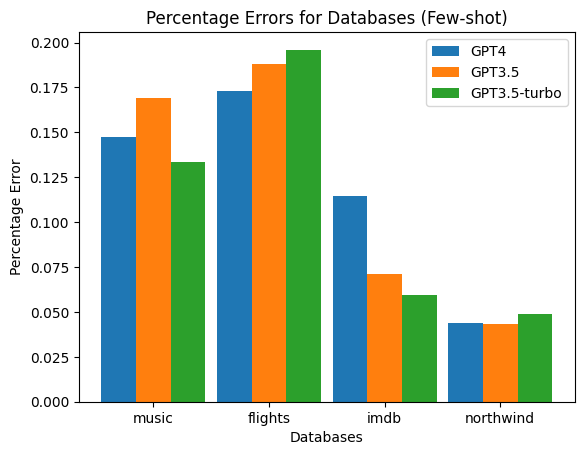

In [59]:
import matplotlib.pyplot as plt

dbs = data2['Database'].unique()
error_lst_4 = [0.14756714916833688, 0.17293643796397534, 0.11434564440528948, 0.043865217152853415]
error_lst_3 = [0.1689049616493543, 0.18784028054528618, 0.071305615198131, 0.04322714602561705]
error_lst_turbo = []
for db in dbs:
  temp = data2[data2['Database']==db]
  error_lst_turbo.append(temp['3_turbo_error'].mean())
print(error_lst_turbo)

X_axis = np.arange(len(dbs))

plt.bar(X_axis - 0.3, error_lst_4, 0.3, label = 'GPT4')
plt.bar(X_axis, error_lst_3, 0.3, label = 'GPT3.5')
plt.bar(X_axis + 0.3, error_lst_turbo, 0.3, label = 'GPT3.5-turbo')

plt.xticks(X_axis, dbs)
plt.xlabel("Databases")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Databases (Few-shot)")
plt.legend()
plt.show()

[0.12134502923976608, 0.0511578141946009, 0.17003751521206417, 0.059523349249704996, 0.12160469009097936, 0.10306165603889673, 0.15471030517470144, 0.5]


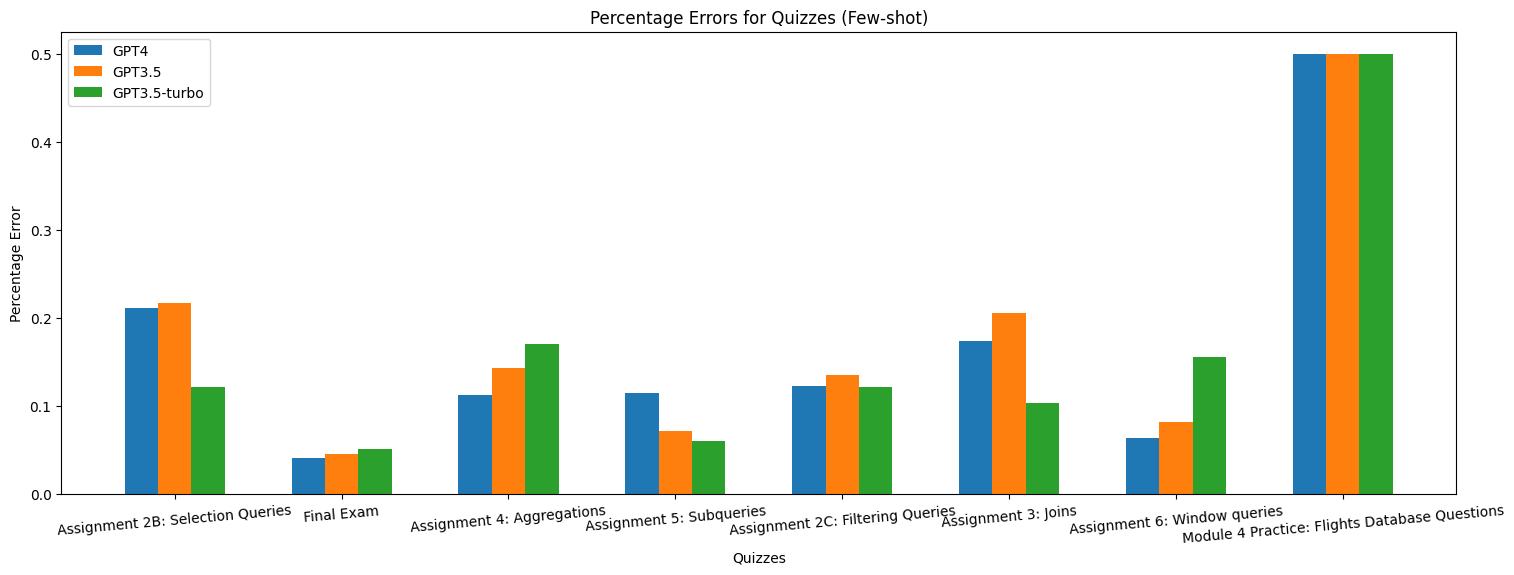

In [65]:
qs = data2['HomeWork'].unique()
# no data for 2B for vanilla so I use 0 here
error_lst_4 = [0.21069206660021933, 0.040215815271279515, 0.11244440380877667, 0.11434564440528948, 0.12229253233712362, 0.17334277671932471, 0.06326530612244897, 0.5]
error_lst_3 = [0.21633431108437085, 0.04523558334247169, 0.14323207702087767, 0.071305615198131, 0.13477970715968038, 0.20565349921645074, 0.0819588294157069, 0.5]
error_lst_turbo = []
for q in qs:
  temp = data2[data2['HomeWork']==q]
  error_lst_turbo.append(temp['3_turbo_error'].mean())
print(error_lst_turbo)

X_axis = np.arange(len(qs))

plt.figure(figsize=(18,6))
plt.bar(X_axis - 0.2, error_lst_4, 0.2, label = 'GPT4')
plt.bar(X_axis, error_lst_3, 0.2, label = 'GPT3.5')
plt.bar(X_axis + 0.2, error_lst_turbo, 0.2, label = 'GPT3.5-turbo')

plt.xticks(X_axis, qs, rotation=5)
plt.xlabel("Quizzes")
plt.ylabel("Percentage Error")
plt.title("Percentage Errors for Quizzes (Few-shot)")
plt.legend()
plt.show()

In [66]:
qs

array(['Assignment 2B: Selection Queries', 'Final Exam',
       'Assignment 4: Aggregations', 'Assignment 5: Subqueries',
       'Assignment 2C: Filtering Queries', 'Assignment 3: Joins',
       'Assignment 6: Window queries',
       'Module 4 Practice: Flights Database Questions'], dtype=object)

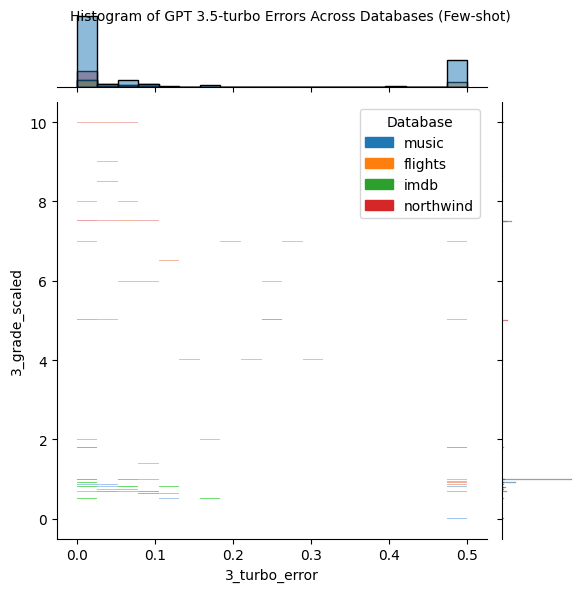

In [68]:
import seaborn as sns

j = sns.jointplot(data=data2, x="3_turbo_error", y="3_grade_scaled", hue="Database", kind='hist')
j.fig.suptitle("Histogram of GPT 3.5-turbo Errors Across Databases (Few-shot)", fontsize=10)

plt.show()

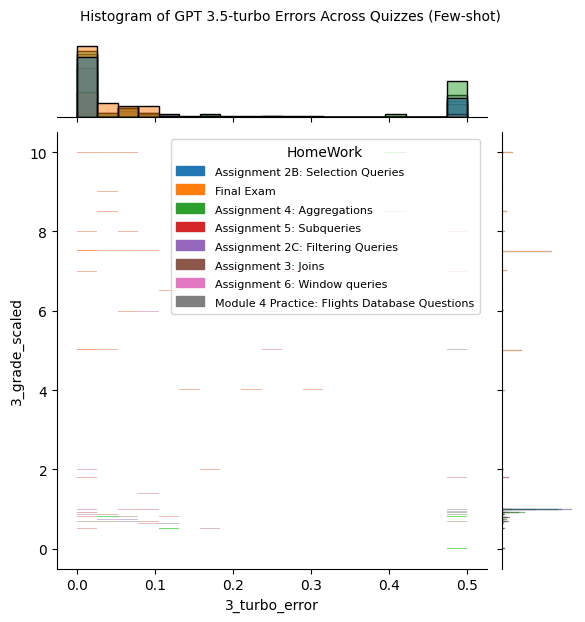

In [76]:
j = sns.jointplot(data=data2, x="3_turbo_error", y="3_grade_scaled", hue="HomeWork", kind='hist')

leg = j.ax_joint.get_legend() # Get the legend object from the figure
for text in leg.get_texts():
    text.set_fontsize(8)  # Set the font size to 'small' or use a numerical value

# Adjust the overall figure title (suptitle) and font size if needed
j.fig.suptitle("Histogram of GPT 3.5-turbo Errors Across Quizzes (Few-shot)", fontsize=10, y=1.03)
plt.show()